In [45]:
import sys, os, time
import shutil
# %pdb
# %load_ext autoreload
# %autoreload 2
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
os.environ['FOUNDATION_SAVE_DIR'] = '/is/ei/fleeb/workspace/chome/trained_nets'
os.environ['FOUNDATION_DATA_DIR'] = '/is/ei/fleeb/workspace/local_data'
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
from IPython import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
import torchvision
# from IPython.display import Image, Pretty, TextDisplayObject, Video
from IPython import display as disp
from IPython.display import display
from torch.utils.data import Dataset, DataLoader, TensorDataset
import gym
import numpy as np
%matplotlib notebook
# %matplotlib tk
import matplotlib.pyplot as plt
import imageio
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont
# plt.switch_backend('Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from bisect import bisect_left

# from IPython.display import HTML, Image
from contextlib import nullcontext, redirect_stdout, redirect_stderr
#from foundation.util import replicate, Cloner

from hybrid import get_model, get_data
from analyze import *

from tqdm import tqdm_notebook as tqdm

plt.ioff()

np.set_printoptions(linewidth=120, suppress=True)

In [46]:
M = Hybrid_Controller('/is/ei/fleeb/workspace/media/hybrid/final').filter_strs('!test')

Found 127 runs


In [47]:
import os
root = '/is/ei/fleeb/workspace/media/hybrid/final'

In [48]:
dirs = []
for r in os.listdir(root):
    if 'viz' in os.listdir(os.path.join(root, r)):
        print(r)
        dirs.append(r)

3dshapes-ae_0030-6046949-00_200131-125923_ckpt30
3dshapes-ae_0035-6048636-02_200131-185834_ckpt30
3dshapes-dae_0030-6046949-02_200131-125904_ckpt30
3dshapes-dae_0035-6048636-06_200131-185348_ckpt30
3dshapes-fae_0031-6046954-00_200131-132552_ckpt30
3dshapes-fae_0035-6048636-07_200131-185701_ckpt30
3dshapes-fvae_0029-6046947-06_200131-125026_ckpt30
3dshapes-fvae_0035-6048636-08_200131-185352_ckpt30
3dshapes-fwae_0028-6046939-05_200131-124815_ckpt30
3dshapes-vae_0028-6046939-02_200131-124807_ckpt30
3dshapes-vae_0028-6046939-03_200131-124821_ckpt30
3dshapes-vae_0035-6048636-04_200131-185348_ckpt30
3dshapes-vae_0035-6048636-05_200131-185514_ckpt30
3dshapes-wae_0028-6046939-01_200131-124832_ckpt30
3dshapes-wae_0035-6048636-03_200131-185353_ckpt30
box-s3-ae_0074-6051172-00_200202-205115_ckpt51
box-s3-dae_0079-6051322-01_200203-020055_ckpt51
box-s3-fae_0074-6051172-04_200202-211819_ckpt51
box-s3-fvae_0074-6051172-06_200202-211800_ckpt51
box-s3-fwae_0074-6051172-05_200202-211800_ckpt51
box-s3-v

In [49]:
len(dirs)

127

In [50]:
import tarfile, shutil
import os.path

In [51]:
# for d in dirs:
#     if 'traversals' in os.listdir(os.path.join(root, d, 'viz')):
#         # find walks dirs
#         path = os.path.join(root, d, 'viz', 'traversals')
#         walks = [n for n in os.listdir(path) if os.path.isdir(os.path.join(path,n))]
#         if len(walks):
#             print(d, len(walks))
#             tarpath = os.path.join(path, 'frames.tar.gz')
#             with tarfile.open(tarpath, 'w:gz') as tar:
#                 for w in walks:
#                     tar.add(os.path.join(path,w))#, arcname=os.path.basename(tarpath))
#             print('\tsaved', tarpath)
            
#             # remove uncompressed
#             for w in walks:
#                 shutil.rmtree(os.path.join(path,w))
#             print('\tcleaned')

In [52]:
final_jobs = {
    'box-s3': {'ae':'74-0', 'wae':'74-1', 'vae':'74-2', 'bvae':'74-3', 'fae':'74-4', 'fwae':'74-5', 
               'fvae':'74-6', 'dae':'79-1', },
    'nocap2cap': {'ae':'86-0', 'wae':'86-1', 'vae':'86-2', 'bvae':'86-3', 'fae':'99-0', 'dae':'99-1', 
                  'fwae':'86-4', 'fvae':'86-5', },
    'spaceinv': {'wae':'64-1', '4vae':'64-3', 'fwae':'64-5', 'fvae':'64-7', 'ae':'64-0', 'vae':'64-2', 
                 '16vae':'64-4', 'fwaes':'64-6', 'fdwaes':'64-11', 'fdwae':'64-10', 'dvae':'64-8', 'dwae':'64-9'},
    '3dshapes': {'ae':'30-0','wae':'28-1', 'vae':'28-2', 'bvae':'28-3', 'fae':'31-0', 'dae':'30-2', 
                 'fwae':'28-5', 'fvae':'29-6'},
    '3dshapes-adain': {'ae':'35-2','wae':'35-3','vae':'35-4','bvae':'35-5','dae':'35-6','fwae':'35-7','fvae':'35-8'},
    'celeba': {'ae':'51-0','wae':'51-1','vae':'51-2','4vae':'51-3','16vae':'51-4','fwae':'51-5',
               'fwaes':'51-6', 'fvae':'51-7', 'dae':'103-1', 'fae':'103-0', 'dwae':'51-9', 
               'fdwae':'51-10', 'fdwae.1':'51-11'},
    'celeba-adain': {'ae':'55-0', 'wae':'55-1', 'fwae':'55-5', 'fwaes':'55-6'},
    'mpi-toy': {'ae':'58-0','wae':'58-1','vae':'58-2', '4vae':'58-3', '16vae':'58-4', 
                'fwae':'58-5', 'fwaes':'58-6', 'fdwae':'58-10', 'dvae':'58-8'},
    'mpi-toy-adain': {'ae':'80-0', 'wae':'80-1', 'vae':'80-2', '4vae':'80-3', '16vae':'80-4', 'fwae':'80-5', 
                      'fvae':'80-7', },# '80-10'
    'mpi-real': {'ae':'72-0', 'wae':'72-1', 'vae':'72-2', '4vae':'72-3', '16vae':'72-4', 'fwae':'72-5', 
                 'fwaes':'72-6', 'fvae':'72-7'},
    'mpi-realistic': { 'wae':'78-1', 'vae':'78-2', '4vae':'78-3', '16vae':'78-4', 'fwae':'78-5', 
                      'fwaes':'78-6', 'fvae':'78-7'},# '78-0',
    
    'arch': {'reg':'30-0', 's2-d4':'35-2', 's3-d0':'88-0', 's1-d8':'88-1', 's2-d4(2)':'88-2', 
             's1-d0':'88-3', 's1-d2':'88-4'},
    
    'box': {'ae':'45-0',  'wae':'45-1', 'vae':'45-2', '4vae':'45-3', 'fae':'45-4', 'dae':'45-5', 
            'fwae':'45-6', 'fvae':'45-7'},
    'box-s1': {'ae':'47-1', 'wae':'47-2', 'vae':'47-3', '4vae':'47-4', 'fae':'47-5', 'dae':'67-0', 
               'fwae':'47-6', 'fvae':'47-7'},
    'box-s2': {'ae':'60-0', 'wae':'60-1', 'vae':'60-2', '4vae':'60-3', 'fae':'60-4',  'dae':'76-0', 
               'fwae':'60-5', 'fvae':'60-6'},
    
    'nocap': {'ae':'71-0', 'wae':'71-1', 'vae':'71-2', '4vae':'71-3', 'fae':'71-4', 'dae':'71-5', 
              'fwae':'71-6', 'fvae':'71-7'},
    
    'pacman': {'ae':'96-0', 'wae':'96-1', 'vae':'96-2', '16vae':'96-4','fwae':'96-5', 'fwaes':'96-6', 
               'dvae':'96-8', 'dwae':'96-9', 'fdwae':'96-10', 'fdwae.1':'96-11'},
}

In [53]:
# M.clear_filters().filter_strs('!test').filter_jobs(167, 168).show_incomplete()

In [54]:
M.clear_run_cache()

In [55]:
M.clear_filters().filter_strs('!test')

M.prep_info(name='model.pth.tar')

M.sort_by('date')
pass
M.show()


Selecting checkpoint: last
Loaded configs
  0) 3dshapes-vae_0028-6046939-02_200131-124807_ckpt30
  1) 3dshapes-fwae_0028-6046939-05_200131-124815_ckpt30
  2) 3dshapes-vae_0028-6046939-03_200131-124821_ckpt30
  3) 3dshapes-wae_0028-6046939-01_200131-124832_ckpt30
  4) 3dshapes-fvae_0029-6046947-06_200131-125026_ckpt30
  5) 3dshapes-dae_0030-6046949-02_200131-125904_ckpt30
  6) 3dshapes-ae_0030-6046949-00_200131-125923_ckpt30
  7) 3dshapes-fae_0031-6046954-00_200131-132552_ckpt30
  8) 3dshapes-dae_0035-6048636-06_200131-185348_ckpt30
  9) 3dshapes-vae_0035-6048636-04_200131-185348_ckpt30
 10) 3dshapes-fvae_0035-6048636-08_200131-185352_ckpt30
 11) 3dshapes-wae_0035-6048636-03_200131-185353_ckpt30
 12) 3dshapes-vae_0035-6048636-05_200131-185514_ckpt30
 13) 3dshapes-fae_0035-6048636-07_200131-185701_ckpt30
 14) 3dshapes-ae_0035-6048636-02_200131-185834_ckpt30
 15) box-ae_0045-6049543-00_200131-224504_ckpt20
 16) box-s1-ae_0047-6049598-01_200201-051024_ckpt26
 17) box-s2-ae_0060-6050841-00_

In [56]:
# M.show('ckpt')

In [57]:
M.clear_run_cache()

In [58]:
# M[0].ckpt_path

In [59]:
# M.sort_by('job')
# print('\n'.join('unbuffer python main_eval.py --legacy 0 --resume {}'.format(n) for n in M.through().name))
# print('\n'.join('unbuffer python main_eval.py --names {} --save-dir /home/fleeb/results/test'.format(n) for n in M.through().name))
# print('\n'.join('unbuffer python main_eval.py --names {} --save-dir /home/fleeb/results/test'.format(n) for n in M.through().name))
# tmpl= 'unbuffer python hybrid.py n/t/nocap2cap --load {}'#' --model.lr 5e-4'
tmpl= 'unbuffer python hybrid.py --legacy 0 --resume {}'

# print('\n'.join(tmpl.format(n) for n in M.through().name))

In [60]:
final_jobs.keys()

dict_keys(['box-s3', 'nocap2cap', 'spaceinv', '3dshapes', '3dshapes-adain', 'celeba', 'celeba-adain', 'mpi-toy', 'mpi-toy-adain', 'mpi-real', 'mpi-realistic', 'arch', 'box', 'box-s1', 'box-s2', 'nocap', 'pacman'])

In [61]:
def _find_jobs(job):
    for run in M:
        j, _, p = run.meta.job
        name = '{}-{}'.format(j,p)
        if job == name:
            return run
#     assert False, job
#     return None

In [62]:
runs = {}
for ds, objs in final_jobs.items():
    runs[ds] = {n:_find_jobs(j) for n, j in objs.items()}
    runs[ds] = {n:v for n,v  in runs[ds].items() if v is not None}
runs.keys()

dict_keys(['box-s3', 'nocap2cap', 'spaceinv', '3dshapes', '3dshapes-adain', 'celeba', 'celeba-adain', 'mpi-toy', 'mpi-toy-adain', 'mpi-real', 'mpi-realistic', 'arch', 'box', 'box-s1', 'box-s2', 'nocap', 'pacman'])

In [63]:
def _label_seq(names, runs, prefix=None):
    for m,r in zip(names, runs):
        r.long_name = r.name
        r.name = m if prefix is None else '{}-{}'.format(prefix,m)
    return runs

In [64]:
# seq = runs['3dshapes']
# run = next(iter(seq.values()))
# len(seq), seq.keys()

In [65]:
M.clear()

# task = '3dshapes'
# M.extend(_label_seq(runs[task].keys(), runs[task].values(), prefix=task))


# task = 'box'
# M.extend(_label_seq(runs[task].keys(), runs[task].values(), prefix=task))


# task = 'box-s1'
# M.extend(_label_seq(runs[task].keys(), runs[task].values(), prefix=task))


# task = 'box-s2'
# M.extend(_label_seq(runs[task].keys(), runs[task].values(), prefix=task))


# task = 'box-s3'
# M.extend(_label_seq(runs[task].keys(), runs[task].values(), prefix=task))


# task = 'nocap2cap'
# M.extend(_label_seq(runs[task].keys(), runs[task].values(), prefix=task))


task = '3dshapes'
M.extend(_label_seq(runs[task].keys(), runs[task].values(), prefix=task))

# task = 'arch'
# M.extend(_label_seq(runs[task].keys(), runs[task].values(), prefix=task))

# task = 'celeba'
# M.extend(_label_seq(runs[task].keys(), runs[task].values(), prefix=task))

# task = 'celeba-adain'
# M.extend(_label_seq(runs[task].keys(), runs[task].values(), prefix=task))

# M.filter_strs('-fvae')

M.show()

  0) 3dshapes-ae
  1) 3dshapes-wae
  2) 3dshapes-vae
  3) 3dshapes-bvae
  4) 3dshapes-fae
  5) 3dshapes-dae
  6) 3dshapes-fwae
  7) 3dshapes-fvae


In [66]:

# del M[13]
# del M[7]
# del M[4]
# del M[3]

In [67]:
run = M[0]

In [68]:
M.load_into('results.pth.tar')

In [69]:
run.results.keys()

dict_keys(['disent', 'O', 'R', 'L', 'Q', 'G', 'H', 'key', 'fid', 'intervention_diffs', 'active_dims'])

In [70]:
# run.results['disent']

In [75]:
def _getstats(run):
    if 'stats' not in run:
        run.stats = util.tdict()
    if 'disent' in run.results:
        stats = run.results['disent']
        run.stats['IRS'] = stats['IRS']['IRS']
        run.stats['DCI-d'] = stats['DCI']['disentanglement']
        run.stats['DCI-i'] = stats['DCI']['informativeness_test']
        run.stats['DCI-c'] = stats['DCI']['completeness']
        run.stats['MIG'] = stats['MIG']['discrete_mig']
        run.stats['FVAE-active'] = stats['FVAE']['num_active_dims']
    run.stats['active_dim'] = run.results['active_dims']
    if 'fid' in run.results:
        fid_scores = run.results['fid']['scores']
        run.stats['FID-rec'] = fid_scores['rec']
        run.stats['FID-prior'] = fid_scores['prior']
        run.stats['FID-hyb'] = fid_scores['hyb']
        run.stats['FID-gap'] = 1 - (fid_scores['hyb'] - fid_scores['rec'])/fid_scores['rec']
M.map(_getstats)
pass

In [76]:
# fig, ax = M.plot_stats('FID-rec','FID-hyb','FID-prior')
# M.show()
# # plt.ylim(110,150)
# fig

In [77]:
import pandas as pd

In [78]:
names = ['AE', 'WAE', 'VAE', 'β-VAE', 'FAE', 'DAE', 'FWAE', 'FVAE']

In [79]:
for r, n in zip(M, names):
    r.fancy = n

In [92]:
palette='muted'

rname = 'Model'
yname = 'Value'
hue = 'Metric'

In [112]:


stats = ['DCI-d','IRS', 'MIG']

df = M.stats_dataframe()

df = df[stats]


# df[['DCI-d', 'MIG', 'IRS',]] = df

df = df.rename(columns={'DCI-d': 'DCI-D', 
#                         'IRS': 'IRS', 
#                         'active_dims': 'Active Dims',
                       })


X = M.through().fancy


df[rname] = X


df = df.reindex([0,1,2,3,6,7,4,5,], copy=True)
df.index = pd.RangeIndex(len(df.index))

if len(stats) > 1:
    df = pd.melt(df, id_vars=rname, var_name=hue, value_name=yname)
else:
    yname = stats[0]
    hue = None
    palette = None

<IPython.core.display.Javascript object>


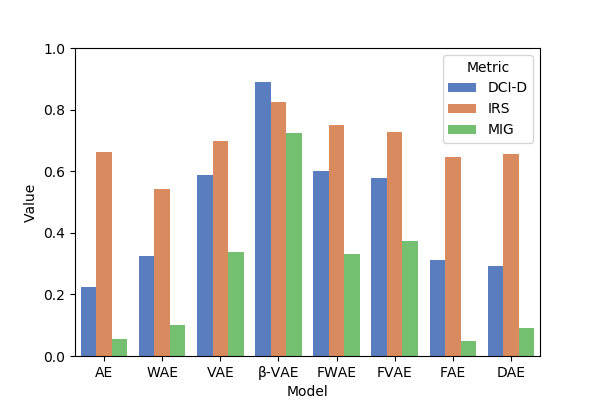

In [134]:


figax = plt.subplots(figsize=(6,4))
fig, ax = figax

sns.barplot(x=rname, y=yname, hue=hue, data=df, ax=ax, palette=palette, orient='v')

plt.ylim(0,1)
# plt.title(', '.join(stats))

fig

In [97]:
# os.mkdir('figures')

In [136]:
# fig.savefig('figures/dis_3dshapes.png')

In [ ]:
stats = 'DCI-d', 'IRS', 'MIG'

In [126]:
print('Model &',' & '.join(stats),r'\\')
print('\midrule')
for r in M:
    print(r.fancy,'&', ' & '.join(['{:.2f}'.format(r.stats[s]) for s in stats]), r'\\')

Model & DCI-d & IRS & MIG \\
\midrule
AE & 0.22 & 0.66 & 0.05 \\
WAE & 0.32 & 0.54 & 0.10 \\
VAE & 0.59 & 0.70 & 0.34 \\
β-VAE & 0.89 & 0.82 & 0.73 \\
FAE & 0.31 & 0.64 & 0.05 \\
DAE & 0.29 & 0.66 & 0.09 \\
FWAE & 0.60 & 0.75 & 0.33 \\
FVAE & 0.58 & 0.73 & 0.37 \\


In [29]:
# fig, ax = M.plot_stats('active_dim', )#'FVAE-active')
# M.show()
# fig

In [30]:
# fig, ax = M.plot_stats('FID-gap')
# M.show()
# fig